In [0]:
!gdown https://drive.google.com/uc?id=1jBF19M8aXiTLXeKOYjH1iuYMgzNaTtSN

Downloading...
From: https://drive.google.com/uc?id=1jBF19M8aXiTLXeKOYjH1iuYMgzNaTtSN
To: /content/histopathologic-cancer-detection.zip
6.77GB [01:30, 74.5MB/s]


In [0]:
import zipfile, os

zip_ref = zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r')
zip_ref.extractall()
zip_ref.close()


**The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).** This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. Dark blue hematoxylin binds to negatively charged substances such as nucleic acids and pink eosin to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.

**Low-resolution**             | **Mid-resolution**            | **High-resolution** 
:-------------------------:|:-------------------------:|:-------------------------:
![](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_low_resolution.png) | ![Example of a metastatic region](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_mid_resolution.png) | ![Example of a metastatic region](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_high_resolution.png)
**[<p style="text-align: center;"> Example of a metastatic region in lymph nodes, CHAMELYON17 </p>](https://camelyon17.grand-challenge.org/Background/)**

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.



----------------------------------------------
# Data understanding
### What data do we have available?

**220k training images and 57k evaluation images.** The dataset is a subset of the [PCam dataset](https://github.com/basveeling/pcam) and the only difference between these two is that all duplicate images have been removed. The PCam dataset is derived from the [Camelyon16 Challenge dataset](https://camelyon16.grand-challenge.org/Data/) which contains 400 H&E stained whole slide images of sentinel lymph node sections that were acquired and digitized at 2 different centers using a 40x objective. The PCam's dataset including this one uses 10x undersampling to increase the field of view, which gives the resultant pixel resolution of 2.43 microns.

According to the data description, there is a 50/50 balance between positive and negative examples in the training and test splits. However, **the training distribution seems to be 60/40 (negatives/positives)**. A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. **Tumor tissue in the outer region of the patch does not influence the label.** This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

**Image file descriptors**

Description | 
:--------:|:-------:
Format | TIF
Size | 96 x 96
Channels | 3
Bits per channel | 8
Data type | Unsigned char
Compression | Jpeg



-----------------------------------------
# Data visualization

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('train_labels.csv')
train_path = 'train/'
test_path = 'test/'
# quick look at the label stats
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

We can see that the negative/positive ratio is not entirely 50/50 as there are 130k negatives and 90k negatives. The ratio is closer to 60/40 meaning that there are 1.5 times more negative images than positives.

### Plot some images with and without cancer tissue for comparison

In [0]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

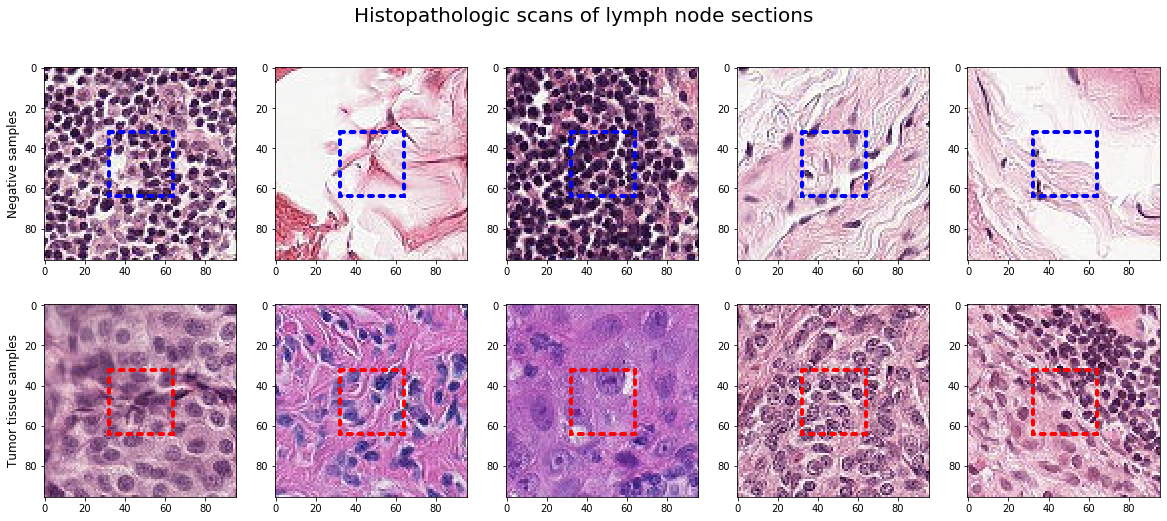

In [0]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. According to [Libre Pathology](https://librepathology.org/wiki/Lymph_node_metastasis), lymph node metastases can have these features:

> - Foreign cell population - key feature (Classic location: subcapsular sinuses)
- Cells with cytologic features of malignancy
    - Nuclear pleomorphism (variation in size, shape and staining).
    - Nuclear atypia:
        - **Nuclear enlargement**.
        - **Irregular nuclear membrane**.
        - **Irregular chromatin pattern, esp. asymmetry**.
        - **Large or irregular nucleolus**.
     - Abundant mitotic figures.
- Cells in architectural arrangements seen in malignancy; highly variable - dependent on tumour type and differentiation.
    - Gland formation.
    - Single cells.
    - Small clusters of cells.
  
**The takeaway from this is probably that irregular nuclear shapes, sizes or staining shades can indicate metastases.**

### How is the data best transformed for modeling?

We know that the label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close.  This hypothesis could be confirmed by training models with varying crop sizes. My initial results with 32 x 32px size showed worse performance than with 48 x 48px but I haven't done a search for optimal size.

### How may we increase the data quality?

We could inspect if the data contains bad data (too unfocused or corrupted) and remove those to increase the overall quality.

### Preprocessing and augmentation
There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions. 

**The augmentations we can use for this type of data:**
- random rotation
- random crop
- random flip (horizontal and vertical both)
- random lighting
- random zoom (not implemented here)
- Gaussian blur (not implemented here)

We will use OpenCV with image operations because in my experience, OpenCV is a lot faster than *PIL* or *scikit-image*.

In [0]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

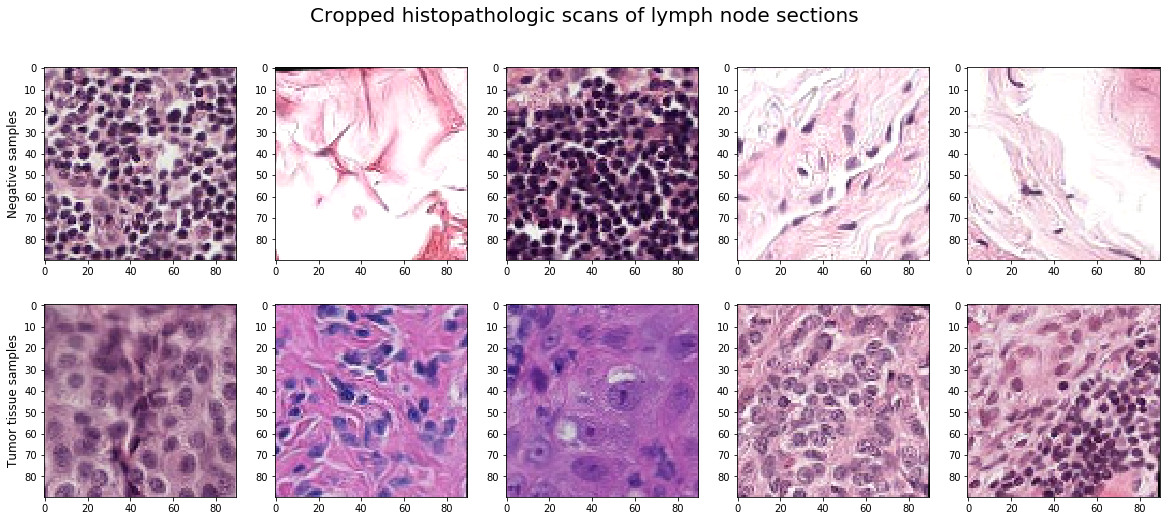

In [0]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

**To see the effects of our augmentation, we can plot one image multiple times.**

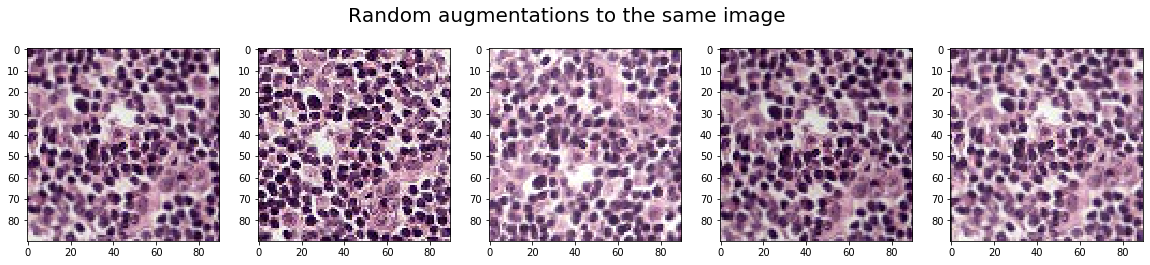

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))